## Важно:

Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось

## Важно 2 (0 - 0.3 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы. 

## Важно 3:

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf файл** с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать модели которые вы использовали (например denoising AE или sparce AE в пункте 1)




In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
%matplotlib inline

# ! pip install wandb



In [ ]:
import wandb

project = 'GM HW1'

В этом домашнем задании мы будем автоэнкодить Omniglot. Omniglot - это датасет в основном для few-shot learning'а, состоящий из рукописных символов из разных существующих и несуществующих (эльфийский, клингонский) языков.

В этом датасете очень много классов, для для каждого класса представлено только 10-20 картинок. Если учить честную классификацию, мы быстро столкнемся с тем, что модель не сможет нормально выучиться.

В этой тетрадке вам предлагается попробовать решить эту проблему - выучить автоэнкодер (любой формы) и, используя латентное его представление, делать классификацию более сложными методами на меньше размерности.

Omniglot очень странно построен, в нем background - это единицы, а не нули. Чтобы перевести это в удобный для нас формат - инвертируем каждый пиксель через нашу кастомную трансформацию - InvertImage


In [ ]:
class InvertImage:
    def __call__(self, pic):
        return 1 - pic

    def __repr__(self):
        return self.__class__.__name__ + '()'


In [ ]:
from omniglot import FullOmniglot
from torchvision import transforms

from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import train_test_split

data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    InvertImage(),
    transforms.Normalize([0.5], [0.5])
])

cuda_num = 0
device = f'cuda:{cuda_num}' if torch.cuda.is_available() else 'cpu'
batch_size = 64


Мы используем кастомный датасет FullOmniglot потому что изначально train/val части омниглота использую разные классы. Мы обьединяем их и делаем свое разбиение

In [ ]:
full_dataset = FullOmniglot('./Omniglot', transform=data_transforms, download=True)

labels = []
for _, label in full_dataset:
    labels.append(label)
    
# делаем так, чтобы сплит был сбалансированным по классам
indices_train, _, indices_test, _ = train_test_split(list(range(len(labels))), labels, test_size=0.1, stratify=labels)

train_dataset = Subset(full_dataset, indices=indices_train)
test_dataset = Subset(full_dataset, indices=indices_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def process_image(image):
    return (image.squeeze().detach().to('cpu') + 1) / 2

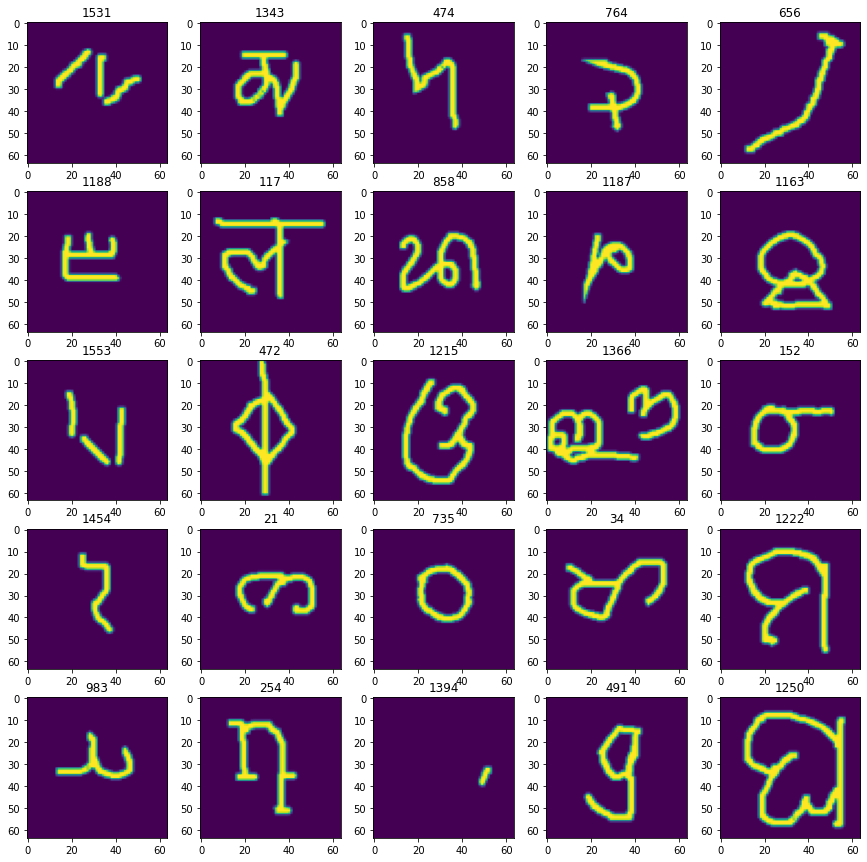

In [ ]:
test_batch = next(iter(train_loader))


plt.figure(figsize=(15, 15))
for ind, (image, label) in enumerate(zip(*test_batch)):
    if ind >= 25: break
    plt.subplot(5, 5, ind+1)
    plt.imshow(process_image(image))
    plt.title(label.item())
plt.show()
    

### Задача 1 (0.3 балла):

Написать свой автоэнкодер, доучить его до приличного качества

Для того чтобы писать красивый код и не делать тетрадку слишком длинной предлагается писать свои модели в отдельном модуле, см `./autoencoder.py`

In [ ]:
# Simple function for wandb logging
import random

def generate_example(model, loader):
    model.eval()

    rand_index = random.randrange(len(loader.dataset))
    image, _ = loader.dataset[rand_index]
    device = next(model.parameters()).device
    image = image.to(device)
    with torch.no_grad():
        reconstructed = model(image.unsqueeze(0)).cpu().numpy()

    example = {'ground truth image': wandb.Image(image),
               'reconstructed image': wandb.Image(reconstructed)
               }

    return example

def train(loader, model, optimizer, criterion):
    losses = []
    model.train()
    device = next(model.parameters()).device
    for image, _ in tqdm(loader, desc='train loop', leave=False):
        optim.zero_grad()
        image = image.to(device)
        out = model(image)
        loss = criterion(out, image)# + 0.001 * calculate_sparse_loss(model, image)
        loss.backward()
        optim.step()
        losses.append(loss.item())

    return losses


def evaluate(loader, model, criterion):
    model.eval()
    losses = []
    
    device = next(model.parameters()).device
    for image, _ in tqdm(loader, desc='valid loop', leave=False):
        image = image.to(device)
        out = model(image)
        loss = criterion(out, image)# + 0.001 * calculate_sparse_loss(model, image)

        losses.append(loss.item())

    return losses

In [ ]:
FIXED_SPARSE_CONST = 0.05

def kl_divergence(x):
    x = x.view(x.shape[0], -1)
    # here we need the probability distributions
    # fortunately we already using sigmoid
    p_hat = torch.mean(x, dim=1)
    p = torch.ones_like(p_hat) * FIXED_SPARSE_CONST
    return torch.sum(p * torch.log(p/p_hat) + (1 - p) * torch.log((1 - p)/(1 - p_hat)))

def calculate_sparse_loss(sae, image):
    loss = 0
    x = image
    for block in sae.encoder[:-1]:
        x = block(x)
        loss += kl_divergence(x)
    x = sae.encoder[-1](x)
    # note that we are using sigmoid on each encoder layer except the last
    loss += kl_divergence(torch.sigmoid(x))
    
    for block in sae.decoder[:-1]:
        x = block(x)
        loss += kl_divergence(x)
    x = sae.decoder[-1](x)
    # note that we are using sigmoid on each decoder layer except the last
    loss += kl_divergence(torch.sigmoid(x))

    return loss

Классический трейнлуп:

Note: я буду уважать вас сильнее если вместо вывода графика в тетрадку вы будете логгировать все (лоссы + картинки) в wandb/comet/neptune. И так далее по ходу тетрадки тоже

In [ ]:
from autoencoder import AutoEncoder, DNAutoEncoder

ae = AutoEncoder().to(device)
optim = torch.optim.Adam(ae.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
name = 'DN Sparse AE training fixed'


wandb.init(project=project, name=name)
wandb.watch(ae);

In [ ]:
epochs = 3

for _ in range(epochs + 1):
    train_loss = train(train_loader, ae, optim, criterion)
    val_loss = evaluate(test_loader, ae, criterion)
    example = generate_example(ae, test_loader)

    train_loss = np.mean(train_loss)
    val_loss = np.mean(val_loss)
    print(train_loss, val_loss)
    example.update({'Train MSE': train_loss, 
                    'Test MSE': val_loss
                    })

    wandb.log(example)


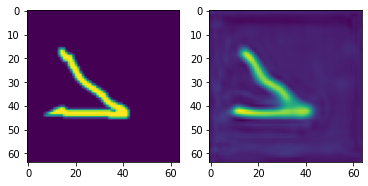

In [ ]:
test_batch = next(iter(test_loader))
ae.eval()

for image in test_batch[0]:
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(ae(image.unsqueeze(0).to(device)).squeeze().detach().to('cpu'))
    plt.show()
    break

Мало посмотреть на результаты глазами, надо еще посчитать метрики качества.

Для этой задачи не очень хочется использовать FID с Inception обученными на ImageNet'е, поэтому предлагается обучить свою модель классификации на MNIST

Это можно сделать здесь (только красиво) или вынести в отдельную тетрадку/файлы

### Задача 2 (0.3 балла):

Научить внешний классификатор классифицировать MNIST, использовать его в подсчете FID между реальным Omniglot и выходами автоэнкодера

In [ ]:
from torchvision.datasets import MNIST

mnist_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

mnist_dataset = MNIST('./MNIST', train=True, transform=mnist_transforms, download=True)
mnist_loader = DataLoader(mnist_dataset, batch_size=batch_size, drop_last=True, shuffle=True)


In [ ]:
def clf_train(loader, model, optimizer, criterion):
    losses = []
    total, correct = 0, 0
    model.train()
    device = next(model.parameters()).device
    for image, label in tqdm(loader, desc='train loop', leave=False):
        optimizer.zero_grad()
        image, label = image.to(device), label.to(device)
        # print(image.shape)
        out = model(image)
        _, predicted = torch.max(out.data, 1)
        # print(out.shape, label.shape)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        total += label.size(0)
        correct += (predicted == label).sum().item()

    return losses, correct / total


def clf_evaluate(loader, model, criterion):
    model.eval()
    losses = []
    total, correct = 0, 0
    device = next(model.parameters()).device
    for image, label in tqdm(loader, desc='valid loop', leave=False):
        image, label = image.to(device), label.to(device)
        out = model(image)
        _, predicted = torch.max(out.data, 1)
        loss = criterion(out, label)

        losses.append(loss.item())

        total += label.size(0)
        correct += (predicted == label).sum().item()

    return losses, correct / total

In [ ]:
from classifier import Classifier

clf = Classifier(10).to(device)
optim = torch.optim.Adam(clf.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
name = 'CLF training fixed'


wandb.init(project=project, name=name)
wandb.watch(clf);

In [ ]:
epochs = 15

for _ in range(epochs):
    train_loss, train_accuracy = clf_train(mnist_loader, clf, optim, criterion)

    train_loss = np.mean(train_loss)

    example = {'Train CE': train_loss, 
               'Train accuracy': train_accuracy
               }

    wandb.log(example)


In [ ]:
from calculate_fid import calculate_fid

print(f"FID for AE: {calculate_fid(test_loader, ae, clf)}")

FID for AE: 99.41083897425688


In [ ]:
class NoiseRecoModel(nn.Module):
    def __init__(self, intensivity=0.1):
        super().__init__()
        # self.placeholder_layer
        # ненужный слой, который позвоняет в calculate_fid смотреть на каком девайсе расположена сетка
        self.placeholder_layer = nn.Linear(1, 1)
        self.intensivity = intensivity
        
    def forward(self, x):
        return x + torch.rand_like(x) * self.intensivity

Проверим насколько наша метрика стабильна: чем больше шум, тем больше она должна становиться

In [ ]:
for noise_level in [0.001, 0.01, 0.05, 0.1, 0.5, 0.7, 1.]:
    noise_model = NoiseRecoModel(noise_level).to(device)
    print(f"FID for noise {noise_level}: {calculate_fid(test_loader, noise_model, clf)}")
    

FID for noise 0.001: 0.00022328367003865424
FID for noise 0.01: 0.02382595420749567
FID for noise 0.05: 0.6179693388507985
FID for noise 0.1: 3.1273630028144908
FID for noise 0.5: 180.79441220653825
FID for noise 0.7: 374.77682516520326
FID for noise 1.0: 803.2671672760316


Реально все работает класс


Понятно что сам по себе автоэнкодер - такая себе генеративная модель, хоть ее и можно использовать в таком качестве

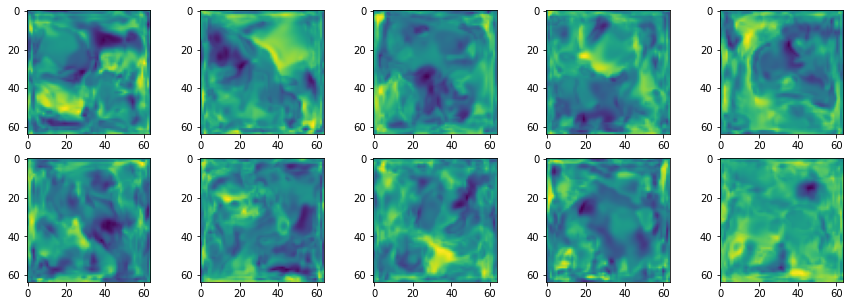

In [ ]:
ae.eval()

test_images = next(iter(test_loader))[0].to(device)
images_latent = ae.get_latent_features(test_images).to('cpu')

test_noise = torch.randn_like(images_latent) * 0.9
sampled_mnist = ae.decoder(test_noise.to(device)).to('cpu')
    
plt.figure(figsize=(15, 5))
for ind in range(10):
    plt.subplot(2, 5, ind+1)
    plt.imshow(sampled_mnist[ind].squeeze().detach())


Мы предлагаем использовать латентные фичи из AE для классификации.

Главная проблема классификации на Omniglot в том, что классов очень много и обычные классификаторы не могут справиться:

### Задача 3 (0.2 балла):

Попробовать честную классификацию на Omniglot, довести ее до приличного качества.

In [ ]:
from classifier import Classifier

clf = Classifier(1623).to(device)
optim = torch.optim.Adam(clf.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
name = 'CLF training Omniglot fixed'


wandb.init(project=project, name=name)
wandb.watch(clf);

In [ ]:
epochs = 30

for _ in range(epochs + 1):
    train_loss, train_accuracy = clf_train(train_loader, clf, optim, criterion)
    test_loss, test_accuracy = clf_evaluate(test_loader, clf, criterion)

    train_loss = np.mean(train_loss)
    test_loss = np.mean(test_loss)

    example = {'Train CE': train_loss, 
               'Train accuracy': train_accuracy,
               'Test CE': test_loss, 
               'Test accuracy': test_accuracy
               }

    wandb.log(example)


Посчитаем аккураси: посчитали выше, логи в W&B. 
Аккураси классификатора на просто картинках уперлось в ~0.65



In [ ]:
print(f"random accuracy: {1/1623}")

random accuracy: 0.0006161429451632779


Возможное решение проблемы с классификацией - обработка данный автоэнкодером и использование преобразованных латентных фичей вместо картинок.

Латентные фичи можно представить в виде табличных 1D данных, на которых можно учить даже разные бустинги.


### Задача 4 (0.2 балла):

Получить латентные представления от картинок в Omniglot, выучить любую (хорошую) модель классификации на них до адекватного качества.

note: не забывайте учить на трейне, а считать аккураси на тесте

Обучать логрег по эпохам что-то не хочется, так что можно без логгирования тут пожалуйста 👉👈

In [ ]:
def get_latent_dataset(dataloader, model):
    data = torch.tensor([])
    target = torch.tensor([])
    for image, label in dataloader:
        image, label = image.to(device), label.to(device)
        latent = model.get_latent_features(image).reshape((image.shape[0], -1))
        data = torch.cat((data, latent.detach().to('cpu')), 0)
        target = torch.cat((target, label.detach().to('cpu')))
    

    return data.numpy(), target.numpy()

In [ ]:
latent_train, y_train = get_latent_dataset(train_loader, ae)
latent_test, y_test = get_latent_dataset(test_loader, ae)


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500)
clf.fit(latent_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
from sklearn.metrics import accuracy_score

pred = clf.predict(latent_test)

print(f"random accuracy: {1/1623}")
print(f"LogReg + AE accuracy train: {accuracy_score(y_train, clf.predict(latent_train))}")
print(f"LogReg + AE accuracy test: {accuracy_score(y_test, pred)}")

random accuracy: 0.0006161429451632779
LogReg + AE accuracy train: 0.7149808114035088
LogReg + AE accuracy test: 0.6807839912280702


In [ ]:
from catboost import CatBoostClassifier

boost = CatBoostClassifier(iterations=10)

In [ ]:
boost.fit(latent_train, y_train)

Learning rate set to 0.5
0:	learn: 7.1765409	total: 8m 38s	remaining: 1h 17m 43s
1:	learn: 6.9362477	total: 17m 18s	remaining: 1h 9m 13s
2:	learn: 6.7182836	total: 25m 54s	remaining: 1h 26s
3:	learn: 6.5143603	total: 34m 24s	remaining: 51m 36s
4:	learn: 6.3129840	total: 42m 59s	remaining: 42m 59s
5:	learn: 6.0937102	total: 51m 33s	remaining: 34m 22s
6:	learn: 5.8835646	total: 1h 9s	remaining: 25m 46s
7:	learn: 5.6964967	total: 1h 8m 50s	remaining: 17m 12s
8:	learn: 5.5154975	total: 1h 17m 30s	remaining: 8m 36s
9:	learn: 5.3355267	total: 1h 26m 7s	remaining: 0us


In [ ]:
from sklearn.metrics import accuracy_score

pred = boost.predict(latent_test)

print(f"random accuracy: {1/1623}")
print(f"Catboost + AE accuracy train: {accuracy_score(y_train, boost.predict(latent_train))}")
print(f"Catboost + AE accuracy test: {accuracy_score(y_test, pred)}")

random accuracy: 0.0006161429451632779
Catboost + AE accuracy train: 0.3397409539473684
Catboost + AE accuracy test: 0.3516995614035088
